# A Bayesian approach for clustering and exact finite-sample model selection in  longitudinal data mixtures - code

Just start by loading some libraries that we will need:

In [1]:
import numpy as np      
from numpy import genfromtxt
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ari  
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

Then we define a nice set of colors to use for next plots:

In [2]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
pal = sns.color_palette(flatui)

and we load the file "functions.py" containing all the libraries and functions needed to implement the estimation algorithm detailed in Section 3 and Appendix E.

In [3]:
exec(open("functions.py").read())    # change "device = cpu" into "device = cuda" at line 17 in functions.py if you have GPU! 

The following lines simulte a dataset $y$ (a matrix with N rows and D columns) whose rows are the trajectories to cluster (cfr. simulated experiment in Section 4.2).

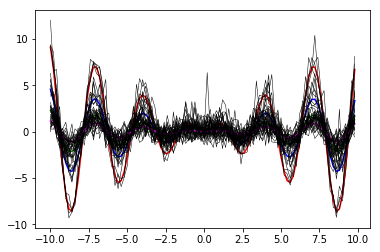

In [4]:
np.random.seed(123)

N = 40
n_samples = 10
residual = 'Gumbel'    # residutal type : Gaussian or Gumbel
sigma = .7             # residual standard deviation 
times = np.arange(-10, 10, step = 0.2) 
D = len(times)
    
trueZ = np.array([0,0,0,0,1,1,1,1,1,1,1,1,2,2,2,2,2,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3])  # true labels

C1 = np.sum(trueZ == 0)
C2 = np.sum(trueZ == 1)
C3 = np.sum(trueZ == 2)
C4 = np.sum(trueZ == 3)
#    trueZ = np.sort(trueZ)


s1 = np.sin(2*times)/1*times  
plt.plot(times, s1, '-r')
if residual == 'Gaussian':
    y1 = s1.reshape((1,-1)) + np.matrix(np.random.normal(0.0, sigma, C1*len(s1))).reshape((C1, len(s1)))
elif residual == 'Gumbel':
    y1 = s1.reshape((1,-1)) + np.matrix(np.random.gumbel(0.0, sigma, C1*len(s1))).reshape((C1, len(s1)))
for idx in range(4):
    plt.plot(times, np.array(y1[idx,:]).ravel(), '-k', linewidth = 0.5)  #red

s2 = np.sin(2*times)/2*times                       
plt.plot(times, s2, '-b')
if residual == 'Gaussian':
    y2 = s2.reshape((1,-1)) + np.matrix(np.random.normal(0.0, sigma, C2*len(s2))).reshape((C2, len(s2)))
elif residual == 'Gumbel':
    y2 = s2.reshape((1,-1)) + np.matrix(np.random.gumbel(0.0, sigma, C2*len(s2))).reshape((C2, len(s2))) 
for idx in range(8):
    plt.plot(times, np.array(y2[idx,:]).ravel(), '-k', linewidth = 0.5)   #b


s3 = np.sin(2*times)/4*times                          
plt.plot(times, s3, '-g')
if residual == 'Gaussian':
    y3 = s3.reshape((1,-1)) + np.matrix(np.random.normal(0.0, sigma, C3*len(s3))).reshape((C3, len(s3)))
elif residual == 'Gumbel':
    y3 = s3.reshape((1,-1)) + np.matrix(np.random.normal(0.0, sigma, C3*len(s3))).reshape((C3, len(s3)))
for idx in range(12): 
    plt.plot(times, np.array(y3[idx,:]).ravel(), '-k', linewidth = 0.5)  #g 

s4 = np.sin(2*times)/8*times  
plt.plot(times, s4, '-m')        
if residual == 'Gaussian':
    y4 = s4.reshape((1,-1)) + np.matrix(np.random.normal(0.0, sigma, C4*len(s4))).reshape((C4, len(s4)))
elif residual == 'Gumbel':
    y4 = s4.reshape((1,-1)) + np.matrix(np.random.normal(0.0, sigma, C4*len(s4))).reshape((C4, len(s4)))
for idx in range(16): 
    plt.plot(times, np.array(y4[idx,:]).ravel(), '-k', linewidth = 0.5) #m          

# the dataset 
y = np.concatenate((y1,y2,y3,y4), axis = 0)

## Clustering

The function **Fit** is now called, either with random or k-means initialization to fit the Bayesian generative model to $y$. In a first time, the number of clusters is fixed to $Q = 4$ and we only focuns on clustering.

In [5]:
from sklearn.cluster import KMeans
import pickle

n_runs = 10

Q = 4

times_cr = (times - np.mean(times))/np.std(times)   # centering and scaling times

store_aris = []
store_icl = []
# km = KMeans(n_clusters=Q).fit(y)
# kZ = km.labels_
kZ = np.random.choice([1,2,3,4], 40) -1     # random initialisation
print("Initial ARI: ", ari(trueZ, kZ))
store_out = []
for run in range(n_runs):
        cZ,eta,a,b,alpha,icl,loss = Fit(y, times_cr, Q, ia = 1.0, ib = 1.0, ieta = 1.2, ialpha = 10, 
                                         sigma = 0.2, kernel_type = 'rbf', 
                                         verbose = 1, Z = (kZ+1).copy(),
                                         )
        store_out.append([cZ,eta,a,b,alpha,icl,loss])
        store_icl.append(icl.cpu())
        store_aris.append(ari(trueZ,cZ))        
best = np.argmax(store_icl)
print("Final adjusted Rand index: ",store_aris[best])
cZ,eta,a,b,alpha,icl,loss = store_out[best]

Initial ARI:  0.03980440936776186
 I am starting with CS-MS steps...
 Classification Step...
 Classification Step...
 Classification Step...
Final Negative ICL: 5979.154296875
 I am starting with CS-MS steps...
 Classification Step...
 Classification Step...
 Classification Step...
Final Negative ICL: 5977.2666015625
 I am starting with CS-MS steps...
 Classification Step...
 Classification Step...
Final Negative ICL: 6061.8134765625
 I am starting with CS-MS steps...
 Classification Step...
 Classification Step...
 Classification Step...
Final Negative ICL: 5935.400390625
 I am starting with CS-MS steps...
 Classification Step...
 Classification Step...
 Classification Step...
 Classification Step...
 Classification Step...
Final Negative ICL: 6047.759765625
 I am starting with CS-MS steps...
 Classification Step...
 Classification Step...
 Classification Step...
Final Negative ICL: 6040.59033203125
 I am starting with CS-MS steps...
 Classification Step...
 Classification Step...
 Cl

Plotting the mean signals **predicted by the model**, together with 95\% confidence regions (the clusters are the estimated ones!): 

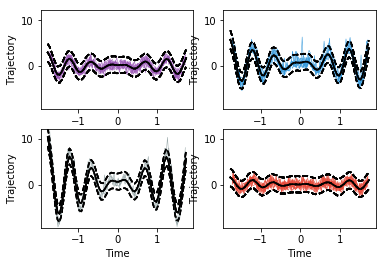

In [6]:
Plot(y, 
     times_cr,
     2, cZ, eta, a, b, 
     kernel_type = "rbf", 
     sigma = 0.2, 
     n_traj = 2000, 
     SplitFigures = False, 
     palette = pal)

## Model Selection
Severeal values of $Q = 1, \dots, 6$ are tested. Ten independent runs for each value of $Q$, the best run is stocked in the list all_out:

In [7]:
n_runs = 10              # number of runs for each model (Q) 

all_out = []  # to store the best fitted models for each Q 
for Q in range(1,6):     # this is about models to test
    print(" Number of clusters: {}".format(Q))
    store_icl = []
    out_list =[]
    km = KMeans(n_clusters=Q).fit(y)
    kZ = km.labels_
    # kZ = np.random.choice([1,2,3,4], 40) -1     # random initialisation
    for run in range(n_runs): 
        cZ, eta, a, b, alpha, icl, loss = Fit(y, times_cr, Q, ia = 1.0, ib = 1.0, ieta = 1.3, ialpha = 10,
                                              kernel_type = "rbf", verbose = 0, sigma = 0.2,
                                              Z = (kZ+1).copy())
        out_list.append([cZ, eta, a, b, alpha, icl.cpu()])
        store_icl.append(icl.cpu())
    best = np.argmax(store_icl)
    all_out.append(out_list[best])

 Number of clusters: 1
 I am starting with CS-MS steps...
Final Negative ICL: inf
 I am starting with CS-MS steps...
Final Negative ICL: inf
 I am starting with CS-MS steps...
Final Negative ICL: inf
 I am starting with CS-MS steps...
Final Negative ICL: inf
 I am starting with CS-MS steps...
Final Negative ICL: inf
 I am starting with CS-MS steps...
Final Negative ICL: inf
 I am starting with CS-MS steps...
Final Negative ICL: inf
 I am starting with CS-MS steps...
Final Negative ICL: inf
 I am starting with CS-MS steps...
Final Negative ICL: inf
 I am starting with CS-MS steps...
Final Negative ICL: inf
 Number of clusters: 2
 I am starting with CS-MS steps...
Final Negative ICL: 5907.1484375
 I am starting with CS-MS steps...
Final Negative ICL: 5907.1484375
 I am starting with CS-MS steps...
Final Negative ICL: 5907.1484375
 I am starting with CS-MS steps...
Final Negative ICL: 5907.1484375
 I am starting with CS-MS steps...
Final Negative ICL: 5907.1484375
 I am starting with CS-M

Looking at the exact ICL for all the tested models (one model for each value of $Q$ in 1,..., 6) and printing the selected number of groups:

In [8]:
best_mod = all_out[0][5]       # The exact ICL of the first model Q = 1
best_idx = 0
for idx in range(len(all_out)):
    if all_out[idx][5]>best_mod:
         best_mod = all_out[idx][5] 
         best_idx = idx                
selected_Q = np.max(all_out[best_idx][0])
print("Selected number of groups: ", selected_Q)

Selected number of groups:  4
